In [1]:
!pip install segmentation-models-pytorch --quiet
!pip install torch torchvision pillow tqdm matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:00


In [2]:
import os
import json
import cv2
import numpy as np
from PIL import Image
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [3]:
from google.colab import files
uploaded = files.upload()  # Upload Vehicle_Damage.zip

import zipfile
zip_path = 'archive (13).zip'
unzip_dir = 'Vehicle_Damage'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

Saving archive (13).zip to archive (13).zip


In [4]:
def create_multiclass_masks_from_coco(coco_json, mask_folder):
    with open(coco_json, 'r') as f:
        coco = json.load(f)
    imgid_to_info = {img['id']: img for img in coco['images']}
    perimg_segments = defaultdict(list)
    all_classes = set()
    for ann in coco['annotations']:
        perimg_segments[ann['image_id']].append(ann)
        all_classes.add(ann['category_id'])
    num_classes = max(all_classes) + 1

    os.makedirs(mask_folder, exist_ok=True)
    for img_id, info in imgid_to_info.items():
        height, width = info['height'], info['width']
        mask = np.zeros((height, width), dtype=np.uint8)
        anns = perimg_segments.get(img_id, [])
        for ann in anns:
            cat = ann['category_id']
            if 'segmentation' in ann:
                for seg in ann['segmentation']:
                    coords = np.array(seg).reshape((-1, 2)).astype(np.int32)
                    cv2.fillPoly(mask, [coords], cat)
        mask_name = info['file_name'].replace('.jpg', '_mask.png')
        Image.fromarray(mask).save(os.path.join(mask_folder, mask_name))
    return num_classes

num_classes_train = create_multiclass_masks_from_coco(
    'Vehicle_Damage/train/COCO_mul_train_annos.json',
    'Vehicle_Damage/train/masks'
)
num_classes_val = create_multiclass_masks_from_coco(
    'Vehicle_Damage/val/COCO_mul_val_annos.json',
    'Vehicle_Damage/val/masks'
)
num_classes = max(num_classes_train, num_classes_val)

In [5]:
def compute_class_counts(mask_dir):
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    max_class = 0
    for mfile in mask_files:
        mask = np.array(Image.open(os.path.join(mask_dir, mfile)))
        this_max = mask.max()
        if this_max > max_class:
            max_class = this_max
    num_classes = max_class + 1
    class_counts = np.zeros(num_classes, dtype=np.int64)
    for mfile in mask_files:
        mask = np.array(Image.open(os.path.join(mask_dir, mfile)))
        for class_idx in range(num_classes):
            class_counts[class_idx] += np.sum(mask == class_idx)
    return class_counts

mask_dir = 'Vehicle_Damage/train/masks'
class_counts = compute_class_counts(mask_dir)
print("Pixel counts per class:", class_counts.tolist())


Pixel counts per class: [40698472, 1908459, 4714480, 5246303, 3489282, 5808988]


In [6]:
class CarDamageMulticlassSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(256, 256), aug=False, num_classes=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.aug = aug
        self.num_classes = num_classes
        self.images = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.resize = transforms.Resize(self.image_size)
        self.to_tensor = transforms.ToTensor()
    def augment(self, image, mask):
        if random.random() > 0.5:
            image, mask = TF.hflip(image), TF.hflip(mask)
        if random.random() > 0.9:
            image, mask = TF.vflip(image), TF.vflip(mask)
        angle = random.uniform(-15, 15)
        image, mask = TF.rotate(image, angle), TF.rotate(mask, angle)
        if random.random() > 0.7:
            image = TF.adjust_brightness(image, brightness_factor=random.uniform(0.8, 1.2))
            image = TF.adjust_contrast(image, contrast_factor=random.uniform(0.8, 1.2))
        return image, mask
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_name = self.images[idx]
        base = os.path.splitext(img_name)[0]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, base + '_mask.png')
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        image = self.resize(image)
        mask = mask.resize(self.image_size, resample=Image.NEAREST)
        if self.aug:
            image, mask = self.augment(image, mask)
        image = self.to_tensor(image)
        mask_np = np.array(mask, dtype=np.uint8)
        mask_tensor = torch.from_numpy(mask_np).long()
        # --- Data checks
        if mask_tensor.min() < 0 or mask_tensor.max() >= self.num_classes:
            raise ValueError(
                f"Mask in {mask_path} out-of-range indices: {mask_tensor.min()} to {mask_tensor.max()}"
            )
        if mask_tensor.ndim != 2:
            raise ValueError(
                f"Mask in {mask_path} should have 2 dims, got {mask_tensor.shape}"
            )
        return image, mask_tensor


In [7]:
train_dataset = CarDamageMulticlassSegmentationDataset(
    image_dir='Vehicle_Damage/train',
    mask_dir='Vehicle_Damage/train/masks',
    aug=True,
    num_classes=num_classes
)
val_dataset = CarDamageMulticlassSegmentationDataset(
    image_dir='Vehicle_Damage/val',
    mask_dir='Vehicle_Damage/val/masks',
    aug=False,
    num_classes=num_classes
)
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [8]:
import torch.nn as nn
import torch

weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
weights = weights / weights.sum()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)


In [9]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name='resnet34',           # Or try: 'resnet50', 'efficientnet-b0', etc.
    encoder_weights='imagenet',        # Pretrained weights
    in_channels=3,
    classes=num_classes
).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [10]:
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # Debug: check classes in batch
        print("Batch GT classes:", torch.unique(masks).tolist())
        print("Batch pred classes:", torch.unique(outputs.argmax(dim=1)).tolist())
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
            print("Val GT classes:", torch.unique(masks).tolist())
            print("Val pred classes:", torch.unique(outputs.argmax(dim=1)).tolist())
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


 12%|█▎        | 1/8 [00:01<00:07,  1.10s/it]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:02<00:01,  2.35it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:02<00:01,  2.63it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:02<00:00,  2.81it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 1/20, Train Loss: 2.1550


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.7521


 12%|█▎        | 1/8 [00:00<00:01,  4.42it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.33it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.35it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.28it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.21it/s]

Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.27it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 2/20, Train Loss: 1.8461


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.7065


 12%|█▎        | 1/8 [00:00<00:01,  4.39it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.37it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.32it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.25it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 3/20, Train Loss: 1.6788


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.6683


 12%|█▎        | 1/8 [00:00<00:01,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.39it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.37it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.34it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.35it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.31it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 4/20, Train Loss: 1.5140


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.4786


 12%|█▎        | 1/8 [00:00<00:01,  4.39it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.31it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.36it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.33it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.32it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.21it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.59it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 5/20, Train Loss: 1.3772


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.3097


 12%|█▎        | 1/8 [00:00<00:01,  4.34it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.22it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.24it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.21it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.24it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.20it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.56it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 6/20, Train Loss: 1.2272


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.2051


 12%|█▎        | 1/8 [00:00<00:01,  4.16it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  3.52it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  3.37it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:01<00:01,  3.34it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  3.31it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  3.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:02<00:00,  3.63it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 7/20, Train Loss: 1.0941


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.1101


 12%|█▎        | 1/8 [00:00<00:01,  4.13it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.24it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.14it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.21it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.17it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.22it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.55it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 8/20, Train Loss: 1.0382


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.0282


 12%|█▎        | 1/8 [00:00<00:01,  4.39it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.36it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.34it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.31it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.33it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 9/20, Train Loss: 0.9368


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.9668


 12%|█▎        | 1/8 [00:00<00:01,  4.26it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.19it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.25it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.30it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.63it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 10/20, Train Loss: 0.9327


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.9548


 12%|█▎        | 1/8 [00:00<00:01,  4.37it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.35it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.35it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.35it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.34it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 11/20, Train Loss: 0.8226


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.9724


 12%|█▎        | 1/8 [00:00<00:01,  4.27it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.37it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.25it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.30it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.30it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 12/20, Train Loss: 0.7560


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.8733


 12%|█▎        | 1/8 [00:00<00:01,  4.45it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  3.80it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  3.57it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:01<00:01,  3.50it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  3.45it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  3.38it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:02<00:00,  3.73it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 13/20, Train Loss: 0.7424


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.8386


 12%|█▎        | 1/8 [00:00<00:01,  4.25it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.20it/s]

Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.23it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.28it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.28it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.59it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 14/20, Train Loss: 0.6796


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.8262


 12%|█▎        | 1/8 [00:00<00:01,  4.21it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.23it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.26it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.27it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.32it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.60it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 15/20, Train Loss: 0.6193


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.8273


 12%|█▎        | 1/8 [00:00<00:01,  4.34it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.31it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.26it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.28it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.28it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.26it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.62it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 16/20, Train Loss: 0.5906


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.8194


 12%|█▎        | 1/8 [00:00<00:01,  4.34it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.23it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.30it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.31it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.29it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.31it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.63it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 17/20, Train Loss: 0.5742


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.7803


 12%|█▎        | 1/8 [00:00<00:01,  4.30it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.23it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.27it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.22it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.26it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.24it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.60it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 18/20, Train Loss: 0.6031


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.8235


 12%|█▎        | 1/8 [00:00<00:01,  4.33it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  3.68it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  3.55it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:01<00:01,  3.44it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  3.36it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  3.39it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:02<00:00,  3.72it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 19/20, Train Loss: 0.5529


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.8386


 12%|█▎        | 1/8 [00:00<00:01,  4.40it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.26it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.31it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.32it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.30it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.31it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 20/20, Train Loss: 0.5658


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.8327


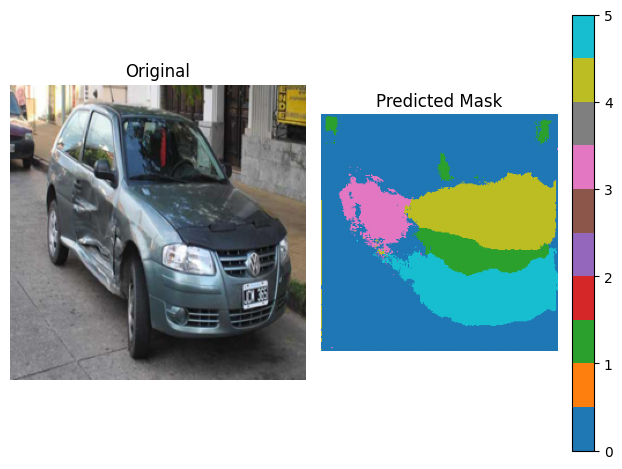

In [11]:
def show_multiclass_mask(model, img_path, device, num_classes):
    import torchvision.transforms as T
    model.eval()
    img = Image.open(img_path).convert('RGB').resize((256, 256))
    img_tensor = T.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img_tensor)
        pred = out.argmax(dim=1)[0].cpu().numpy()
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(pred, cmap='tab10', vmin=0, vmax=num_classes-1)
    plt.colorbar(ticks=range(num_classes))
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
show_multiclass_mask(model, 'Vehicle_Damage/test/28.jpg', device, num_classes)

###Mask Generation from COCO

In [12]:
def create_binary_masks_from_coco(coco_json, mask_folder):
    with open(coco_json, 'r') as f:
        coco = json.load(f)
    imgid_to_info = {img['id']: img for img in coco['images']}
    perimg_segments = defaultdict(list)
    for ann in coco['annotations']:
        perimg_segments[ann['image_id']].append(ann)
    os.makedirs(mask_folder, exist_ok=True)
    for img_id, info in imgid_to_info.items():
        height, width = info['height'], info['width']
        mask = np.zeros((height, width), dtype=np.uint8)
        anns = perimg_segments.get(img_id, [])
        for ann in anns:
            if 'segmentation' in ann:
                for seg in ann['segmentation']:
                    coords = np.array(seg).reshape((-1, 2)).astype(np.int32)
                    cv2.fillPoly(mask, [coords], color=1)
        mask_name = info['file_name'].replace('.jpg', '_mask.png')
        Image.fromarray(mask * 255).save(os.path.join(mask_folder, mask_name))

Generate mask

In [13]:
create_binary_masks_from_coco(
    coco_json='Vehicle_Damage/train/COCO_train_annos.json',
    mask_folder='Vehicle_Damage/train/masks'
)


###Calculate Pixel Class Balance for Binary Masks

In [14]:
def compute_binary_class_counts(mask_dir):
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    class_counts = np.zeros(2, dtype=np.int64)
    for mfile in mask_files:
        mask = np.array(Image.open(os.path.join(mask_dir, mfile)))
        class_counts[0] += np.sum(mask == 0)
        class_counts[1] += np.sum(mask > 0)
    return class_counts

mask_dir = 'Vehicle_Damage/train/masks'
class_counts = compute_binary_class_counts(mask_dir)
print("Pixel counts per class:", class_counts.tolist())  # [background_pixels, damage_pixels]


Pixel counts per class: [55770811, 6095173]


###Binary and Multiclass Segmentation Dataset

In [15]:
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
import random

class CarDamageBinarySegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(256, 256), aug=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.aug = aug
        self.images = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.resize = transforms.Resize(self.image_size)
        self.to_tensor = transforms.ToTensor()

    def augment(self, image, mask):
        if random.random() > 0.5:
            image, mask = TF.hflip(image), TF.hflip(mask)
        if random.random() > 0.9:
            image, mask = TF.vflip(image), TF.vflip(mask)
        angle = random.uniform(-15, 15)
        image, mask = TF.rotate(image, angle), TF.rotate(mask, angle)
        if random.random() > 0.7:
            image = TF.adjust_brightness(image, brightness_factor=random.uniform(0.8, 1.2))
            image = TF.adjust_contrast(image, contrast_factor=random.uniform(0.8, 1.2))
        return image, mask

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        base = os.path.splitext(img_name)[0]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, base + '_mask.png')
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        image = self.resize(image)
        mask = mask.resize(self.image_size, resample=Image.NEAREST)
        if self.aug:
            image, mask = self.augment(image, mask)
        image = self.to_tensor(image)
        mask_np = np.array(mask, dtype=np.uint8)
        mask_tensor = torch.from_numpy((mask_np > 127).astype(np.float32))  # [H, W], float32; 0/1
        return image, mask_tensor.unsqueeze(0)  # [3,H,W], [1,H,W]


Create train & val loaders:

In [16]:
from torch.utils.data import DataLoader

train_dataset = CarDamageBinarySegmentationDataset(
    image_dir='Vehicle_Damage/train',
    mask_dir='Vehicle_Damage/train/masks',
    aug=True
)
val_dataset = CarDamageBinarySegmentationDataset(
    image_dir='Vehicle_Damage/val',
    mask_dir='Vehicle_Damage/val/masks',
    aug=False
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


###Weighted Loss for Class Imbalance

In [17]:
import torch.nn as nn
import torch

# Compute pos_weight for BCEWithLogitsLoss: (background / (damage + epsilon))
background, damage = class_counts
epsilon = 1e-6
pos_weight = torch.tensor([background / (damage + epsilon)], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pos_weight = pos_weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


Pretrained U-Net Model Initialization

In [18]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name='resnet34',      # Pretrained backbone
    encoder_weights='imagenet',   # Pretrained on ImageNet
    in_channels=3,
    classes=1                     # Binary mask output (1 channel)
).to(device)


In [19]:
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


100%|██████████| 8/8 [00:01<00:00,  4.14it/s]


Epoch 1/20, Train Loss: 1.2763
Validation Loss: 0.7504


100%|██████████| 8/8 [00:01<00:00,  4.67it/s]


Epoch 2/20, Train Loss: 1.1689
Validation Loss: 0.7415


100%|██████████| 8/8 [00:01<00:00,  4.74it/s]


Epoch 3/20, Train Loss: 1.0576
Validation Loss: 0.6579


100%|██████████| 8/8 [00:02<00:00,  3.84it/s]


Epoch 4/20, Train Loss: 0.9539
Validation Loss: 0.6999


100%|██████████| 8/8 [00:01<00:00,  4.70it/s]


Epoch 5/20, Train Loss: 0.8678
Validation Loss: 0.7092


100%|██████████| 8/8 [00:01<00:00,  4.77it/s]


Epoch 6/20, Train Loss: 0.8190
Validation Loss: 0.7632


100%|██████████| 8/8 [00:01<00:00,  4.74it/s]


Epoch 7/20, Train Loss: 0.7918
Validation Loss: 0.7354


100%|██████████| 8/8 [00:01<00:00,  4.83it/s]


Epoch 8/20, Train Loss: 0.7277
Validation Loss: 0.5893


100%|██████████| 8/8 [00:01<00:00,  4.81it/s]


Epoch 9/20, Train Loss: 0.6929
Validation Loss: 0.6521


100%|██████████| 8/8 [00:01<00:00,  4.06it/s]


Epoch 10/20, Train Loss: 0.6666
Validation Loss: 0.5347


100%|██████████| 8/8 [00:01<00:00,  4.36it/s]


Epoch 11/20, Train Loss: 0.6210
Validation Loss: 0.5132


100%|██████████| 8/8 [00:01<00:00,  4.61it/s]


Epoch 12/20, Train Loss: 0.6132
Validation Loss: 0.4576


100%|██████████| 8/8 [00:01<00:00,  4.74it/s]


Epoch 13/20, Train Loss: 0.6182
Validation Loss: 0.4958


100%|██████████| 8/8 [00:01<00:00,  4.72it/s]


Epoch 14/20, Train Loss: 0.5636
Validation Loss: 0.4469


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


Epoch 15/20, Train Loss: 0.5625
Validation Loss: 0.4518


100%|██████████| 8/8 [00:01<00:00,  4.06it/s]


Epoch 16/20, Train Loss: 0.5306
Validation Loss: 0.4682


100%|██████████| 8/8 [00:01<00:00,  4.10it/s]


Epoch 17/20, Train Loss: 0.5146
Validation Loss: 0.4506


100%|██████████| 8/8 [00:01<00:00,  4.65it/s]


Epoch 18/20, Train Loss: 0.5161
Validation Loss: 0.3945


100%|██████████| 8/8 [00:01<00:00,  4.71it/s]


Epoch 19/20, Train Loss: 0.4838
Validation Loss: 0.4913


100%|██████████| 8/8 [00:01<00:00,  4.71it/s]


Epoch 20/20, Train Loss: 0.4715
Validation Loss: 0.4445


In [22]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import cv2
import numpy as np
from PIL import Image

def show_mask_outline_on_image(model, img_path, device, threshold=0.5):
    # Load image and predict mask
    image = Image.open(img_path).convert('RGB').resize((256, 256))
    image_tensor = T.ToTensor()(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = torch.sigmoid(model(image_tensor))
        pred_mask = (out[0, 0].cpu().numpy() > threshold).astype(np.uint8)

    img_disp = np.array(image)
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_with_contours = img_disp.copy()
    cv2.drawContours(img_with_contours, contours, -1, (0, 0, 255), thickness=2)
    img_with_contours = cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img_with_contours)
    plt.title("Predicted Damage Outline")
    plt.axis('off')
    plt.show()


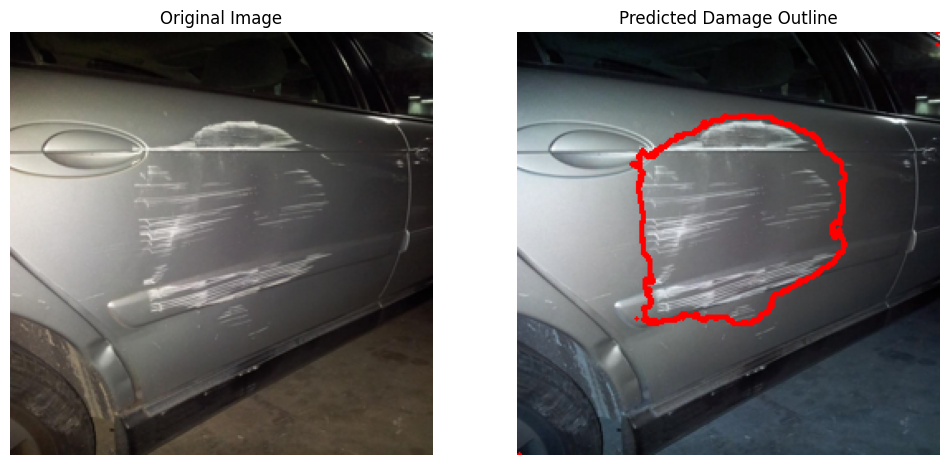

In [23]:
show_mask_outline_on_image(model, 'Vehicle_Damage/test/11.jpg', device, threshold=0.5)